### Library Import

In [20]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

sys.path.append("..")

from src.sanity import *

In [21]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [22]:
from src.load_datasets import load_traffic_data


dataframe = (
    load_traffic_data()
    .pipe(
        select_column,
        cols=[
            "date_time",
            "temp",
            "rain_1h",
            "snow_1h",
            "clouds_all",
            "traffic_volume",
        ],
    )
    .pipe(format_datetime, col="date_time")
    .pipe(set_index, col="date_time")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

dataframe.head()

select_column: DF Shape (48204, 6)
format_datetime: DF Shape (48204, 6)
set_index: DF Shape (48204, 5)
resample_Data: DF Shape (52551, 5)
interpolate_columns: DF Shape (52551, 5)
dataframe shape (52551, 5)


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0


### test_train_split

train_xy and test_xy size: (52521, 5), (30, 5)

y_train and x_train size (52521,), (52521, 4)
y_test  and x_test  size (30,),  (30, 4)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='traffic_volume'>)

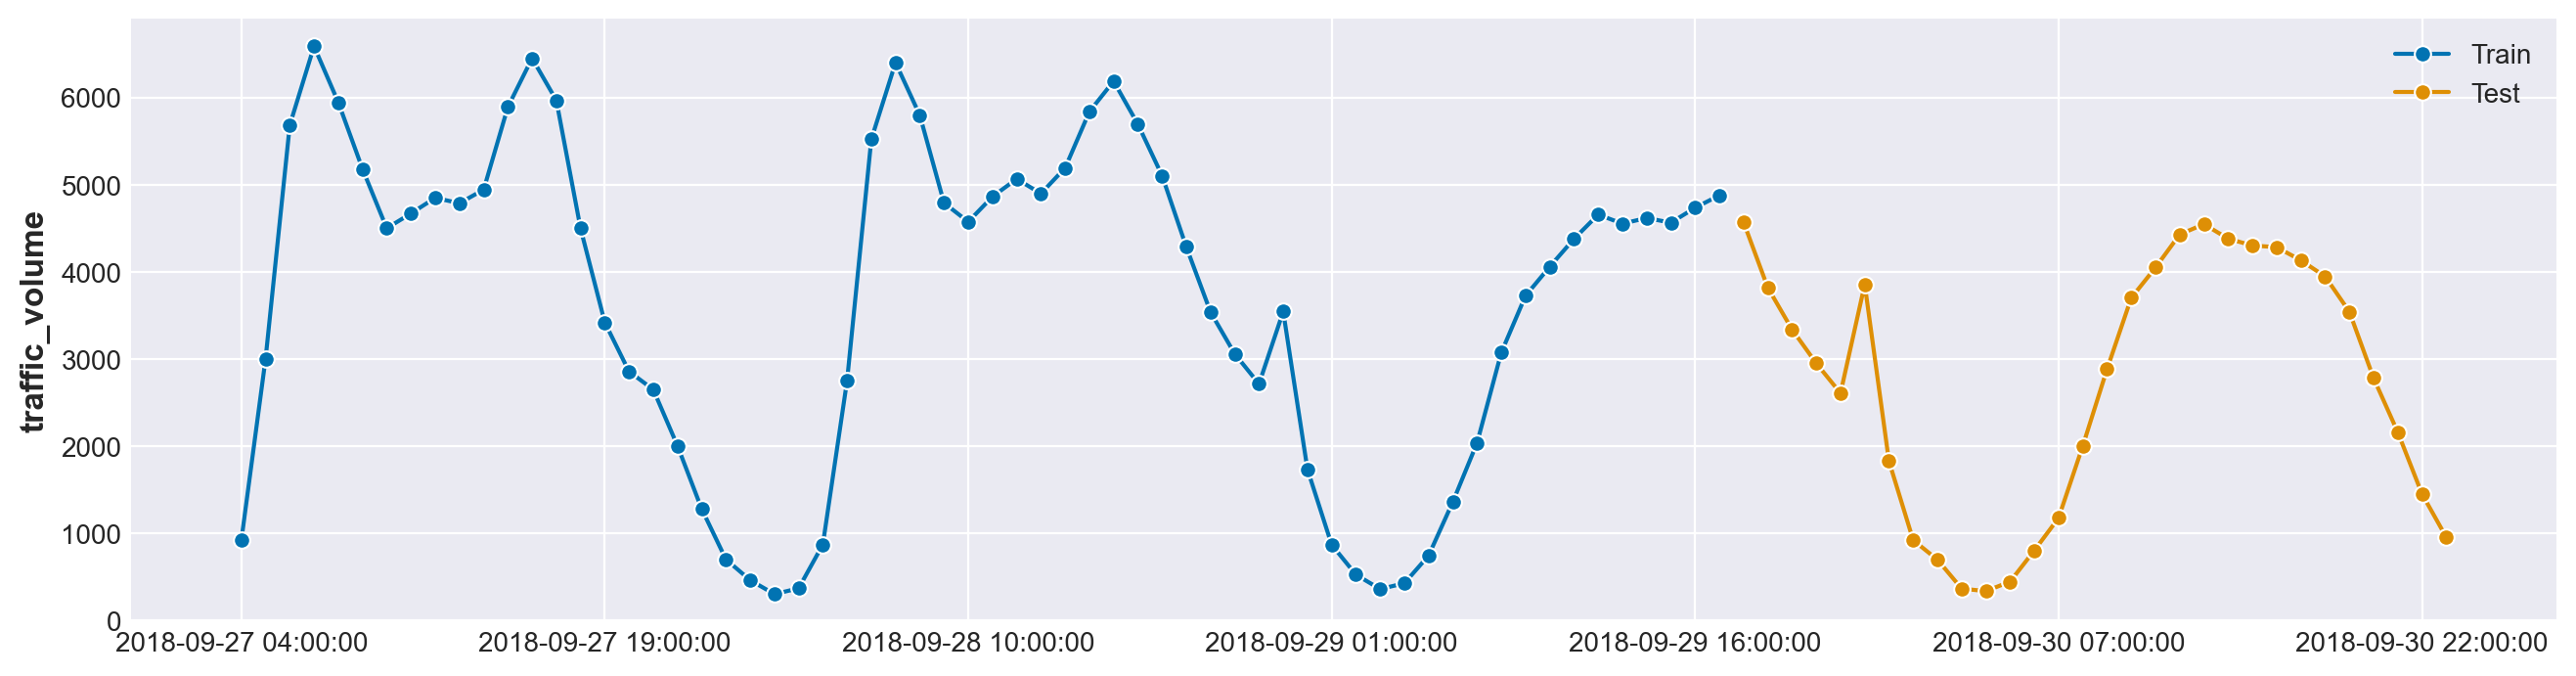

In [23]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "traffic_volume"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=2 * TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

In [24]:
import joblib

trained_model = joblib.load("../results/HuberRegressor.pkl")


model_n_features_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = trained_model.get_fitted_params()["forecaster__reducer__estimator__coef"]
model_intercept = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 28

model_fname_in ['traffic_volume_lag_1' 'traffic_volume_lag_2' 'traffic_volume_lag_3'
 'traffic_volume_lag_4' 'traffic_volume_lag_5' 'traffic_volume_lag_6'
 'traffic_volume_lag_7' 'traffic_volume_lag_8' 'traffic_volume_lag_9'
 'traffic_volume_lag_10' 'traffic_volume_lag_11' 'traffic_volume_lag_12'
 'traffic_volume_lag_13' 'traffic_volume_lag_14' 'traffic_volume_lag_15'
 'traffic_volume_lag_16' 'traffic_volume_lag_17' 'traffic_volume_lag_18'
 'traffic_volume_lag_19' 'traffic_volume_lag_20' 'traffic_volume_lag_21'
 'traffic_volume_lag_22' 'traffic_volume_lag_23' 'traffic_volume_lag_24'
 'temp' 'rain_1h' 'snow_1h' 'clouds_all']

model_coeff [ 1.03228366e+00 -2.35291324e-01 -4.66506469e-02  3.52675587e-03
  3.27676525e-02 -4.60316835e-03 -3.27492375e-02  3.26853289e-02
  2.01968399e-02  3.10646826e-02 -6.39010951e-02 -9.95242551e-02
  6.52815673e-02  4.99751560e-02  1.22805652e-02 -6.31805584e-02
  4.72432207e-03  1.87613556e-02  1.25132501e-02 -3.20236442e-02
  8.71

In [25]:
print(x_test.columns)

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all'], dtype='object')


### Forecasting

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='traffic_volume'>)

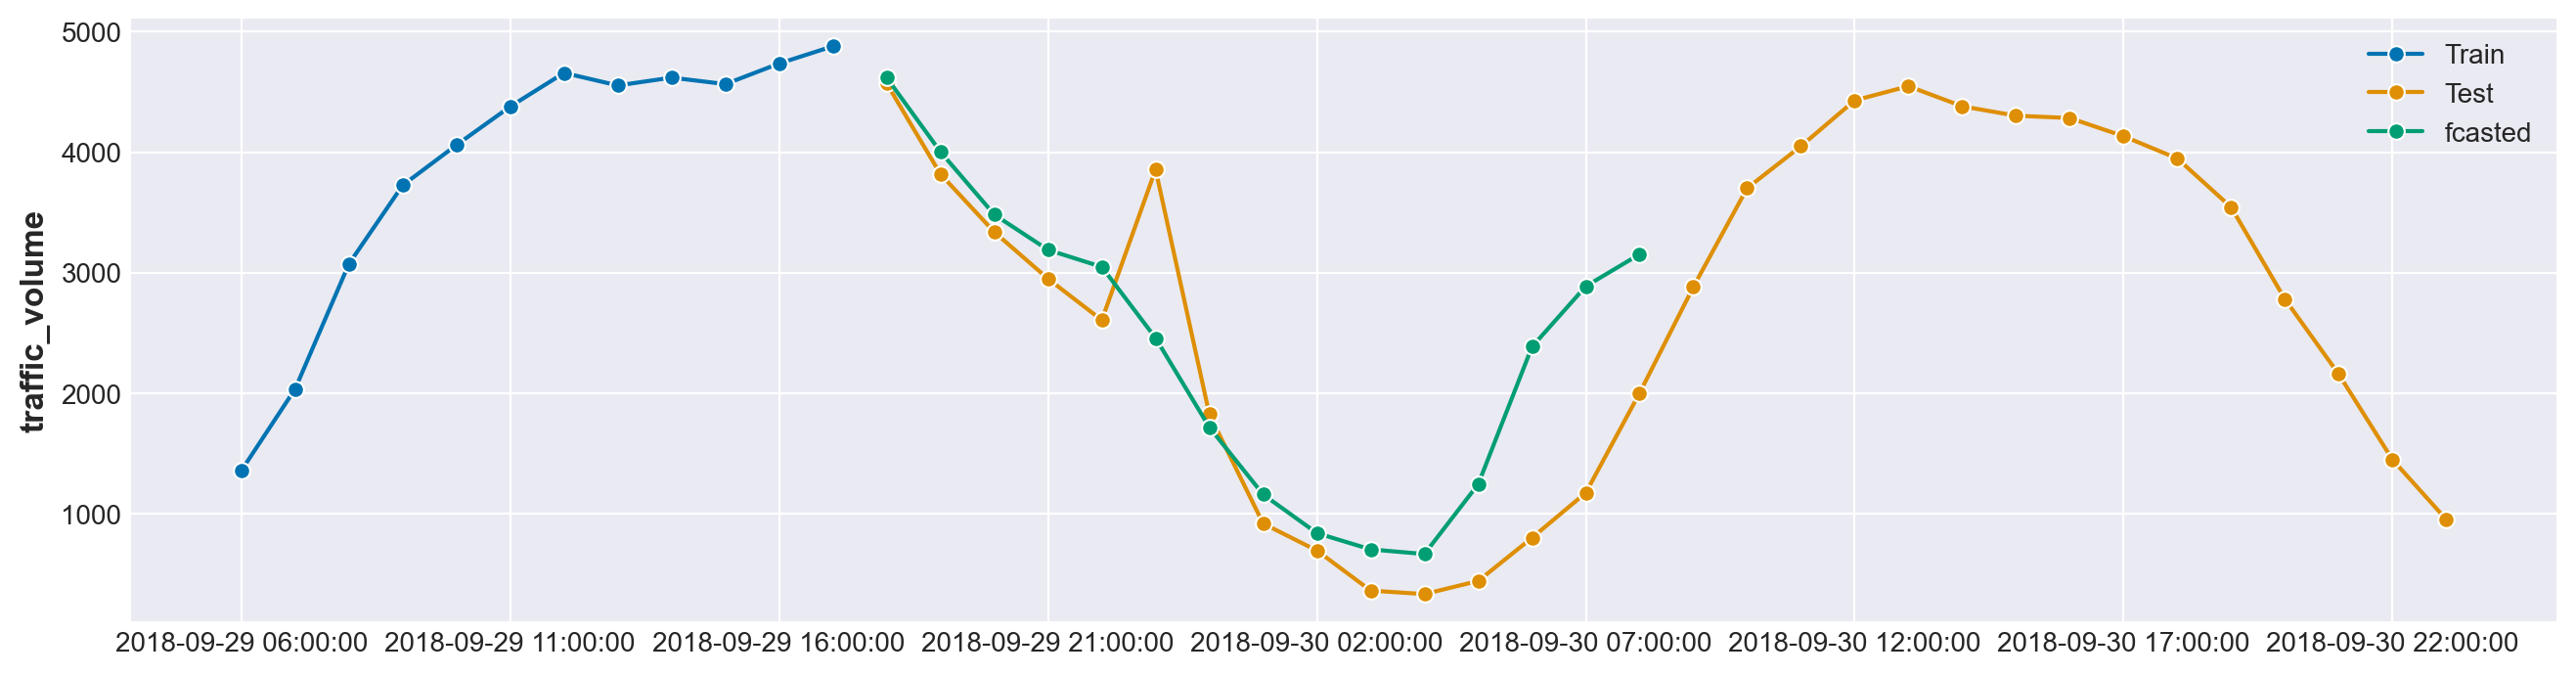

In [26]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_test)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])

In [29]:
y_fcasted

,traffic_volume
2018-09-29 18:00:00,4617.439272
2018-09-29 19:00:00,4002.574040
2018-09-29 20:00:00,3482.169712
2018-09-29 21:00:00,3189.483594
2018-09-29 22:00:00,3048.448462
2018-09-29 23:00:00,2458.177799
2018-09-30 00:00:00,1718.482746
2018-09-30 01:00:00,1161.135089
2018-09-30 02:00:00,840.750277
2018-09-30 03:00:00,705.500575


In [27]:
print(trained_model.cutoff)

DatetimeIndex(['2018-09-29 17:00:00'], dtype='datetime64[ns]', name='date_time', freq='H')


In [28]:
print(test_xy.shape)
test_xy.head()

(30, 5)


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2018-09-29 18:00:00,281.02,0.0,0.0,90.0,4569.0
2018-09-29 19:00:00,280.68,0.0,0.0,90.0,3818.0
2018-09-29 20:00:00,280.55,0.0,0.0,90.0,3338.0
2018-09-29 21:00:00,280.40,0.0,0.0,90.0,2950.0
2018-09-29 22:00:00,280.54,0.0,0.0,90.0,2607.0


In [10]:
test_xy_new = test_xy.head(TEST_SIZE)
test_xy_future = test_xy.tail(TEST_SIZE)
print(test_xy_new.shape, test_xy_future.shape)

(15, 5) (15, 5)


In [11]:
test_xy_new.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
Date Time,,,,,
2016-12-31 05:00:00,1006.686667,-4.993333,267.655000,-8.303333,77.450000
2016-12-31 06:00:00,1006.645000,-5.438333,267.213333,-8.980000,76.033333
2016-12-31 07:00:00,1006.408333,-6.233333,266.438333,-8.996667,80.650000
2016-12-31 08:00:00,1006.228333,-6.646667,266.041667,-8.661667,85.483333
2016-12-31 09:00:00,1006.155000,-6.115000,266.578333,-8.381667,83.866667


In [12]:
test_xy_future.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
Date Time,,,,,
2016-12-31 10:00:00,1005.878333,-4.650000,268.060000,-7.466667,80.533333
2016-12-31 11:00:00,1005.196667,-2.726667,270.031667,-6.413333,75.666667
2016-12-31 12:00:00,1004.346667,0.218333,273.041667,-5.378333,65.935000
2016-12-31 13:00:00,1003.616667,2.555000,275.430000,-4.076667,61.498333
2016-12-31 14:00:00,1003.150000,4.618333,277.528333,-3.495000,55.488333


In [13]:
y_new = test_xy_new.pop(TARGET_COl)
test_xy_new.head()

,p (mbar),T (degC),Tpot (K),rh (%)
Date Time,,,,
2016-12-30 19:00:00,1008.906667,-1.171667,271.301667,86.933333
2016-12-30 20:00:00,1009.050000,-2.058333,270.403333,92.333333
2016-12-30 21:00:00,1009.190000,-2.256667,270.195000,87.166667
2016-12-30 22:00:00,1008.908333,-2.801667,269.671667,86.066667
2016-12-30 23:00:00,1008.761667,-3.586667,268.896667,87.650000


In [14]:
y_new.head()

Date Time
2016-12-30 19:00:00   -3.065000
2016-12-30 20:00:00   -3.128333
2016-12-30 21:00:00   -4.088333
2016-12-30 22:00:00   -4.800000
2016-12-30 23:00:00   -5.335000
Freq: H, Name: Tdew (degC), dtype: float64

In [15]:
# trained_model.update(y_new,X=test_xy_new,update_params=False)

y_new_fcasted = trained_model.update_predict(
    y_new, X=test_xy_new, update_params=False, reset_forecaster=False
)

In [16]:
print(trained_model.cutoff)

DatetimeIndex(['2016-12-31 08:00:00'], dtype='datetime64[ns]', name='Date Time', freq='H')


In [17]:
y_future = test_xy_future.pop(TARGET_COl)
fh = np.arange(1, TEST_SIZE + 1)

y_future_fcated = trained_model.predict(fh, X=test_xy_future)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tdew (degC)'>)

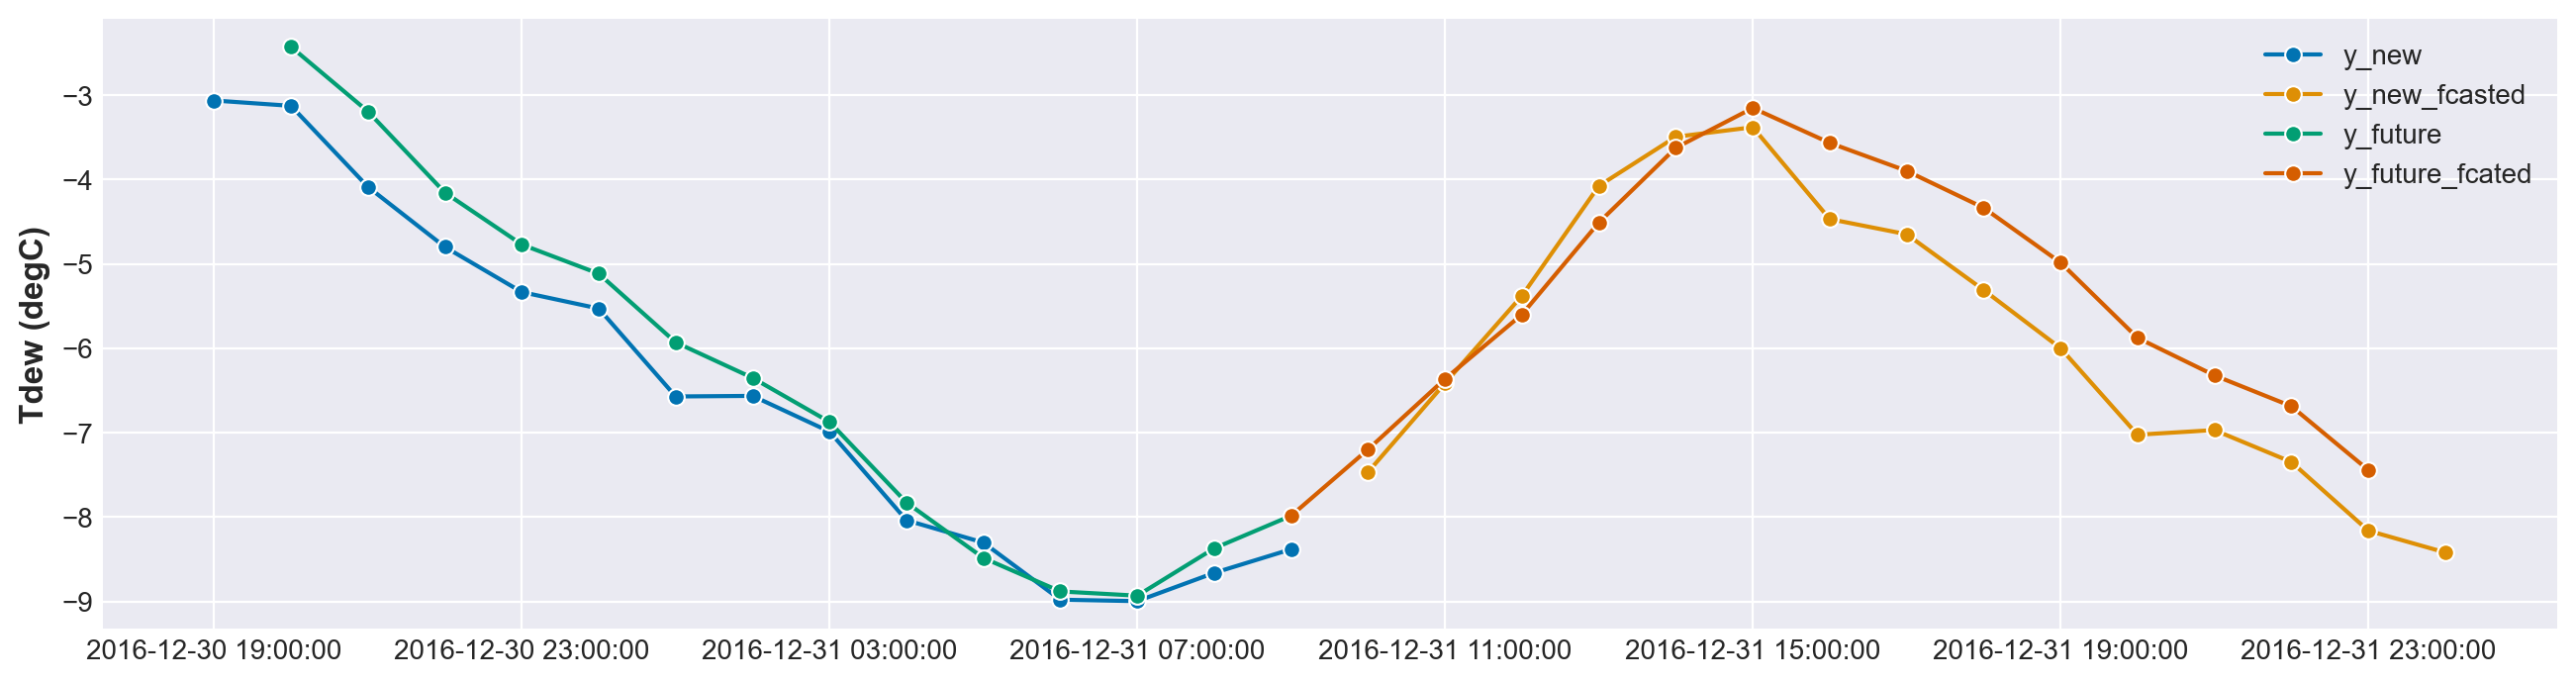

In [18]:
plot_series(
    y_new,
    y_new_fcasted,
    y_future,
    y_future_fcated,
    labels=["y_new", "y_new_fcasted", "y_future", "y_future_fcated"],
)

### No Input Graurd in Fitted Model 

In [19]:
x_modified = x_test[["press", "wnd_spd", "snow", "rain", "dewp", "temp"]]
x_modified.head()

KeyError: "None of [Index(['press', 'wnd_spd', 'snow', 'rain', 'dewp', 'temp'], dtype='object')] are in the [columns]"

In [ ]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_modified)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])